# LeNet-300-100: MNIST + PyTorch

Linear learning-rate warmup followed by step-decay.

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os, pickle
from tqdm import tqdm
from tqdm import trange

In [3]:
print(f"torch version: {torch.__version__}")


# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.0
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce RTX 3080 Laptop GPU
Available device is cuda


In [4]:
# Specify hyper-parameters
batch_size = 256
num_classes = 10
num_epochs = 85

In [5]:
# MNIST dataset statistics:
# mean = tensor([0.1307]) & std dev = tensor([0.3081])
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std = std_dev)
    ])
     

# MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
        root = 'C:/Users/arjun/Downloads/data/', train = True,
        transform = transforms_apply, download = True
        )

test_dataset = torchvision.datasets.MNIST(
        root = 'C:/Users/arjun/Downloads/data/', train = False,
        transform = transforms_apply
        )

In [6]:
# Create dataloader-
train_loader = torch.utils.data.DataLoader(
        dataset = train_dataset, batch_size = batch_size,
        shuffle = True
        )

test_loader = torch.utils.data.DataLoader(
        dataset = test_dataset, batch_size = batch_size,
        shuffle = False
        )

In [7]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [8]:
# Sanity check-
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [9]:
# Reshape input so that it can be fed into LeNet-300-100 architecture model-
X.reshape(-1, 28 * 28 * 1).shape

torch.Size([256, 784])

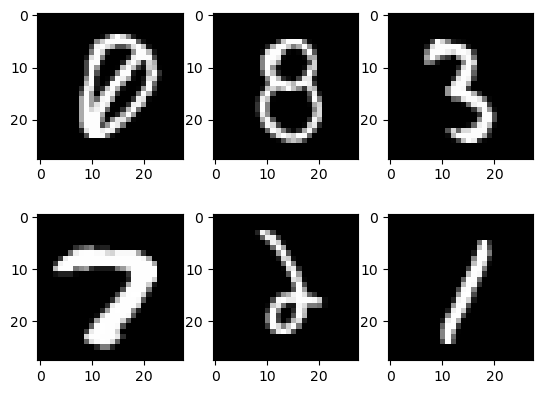

In [10]:
# Print 6 images from training set-
for i in range(6):
    plt.subplot(2, 3, i + 1)    # 2 rows & 3 columns
    plt.imshow(X[i][0], cmap = 'gray')     # '0' to access first channel
plt.show()

In [11]:
del X, y

In [12]:
class LeNet300(nn.Module):
    def __init__(self):
        super(LeNet300, self).__init__()
        
        # Define layers-
        self.fc1 = nn.Linear(in_features = 28 * 28 * 1, out_features = 300)
        self.fc2 = nn.Linear(in_features = 300, out_features = 100)
        self.output = nn.Linear(in_features = 100, out_features = 10)
        
        self.weights_initialization()
    
    
    def forward(self, x):
        out = F.leaky_relu(self.fc1(x))
        out = F.leaky_relu(self.fc2(out))
        return self.output(out)
    
    
    def weights_initialization(self):
        '''
        When we define all the modules such as the layers in '__init__()'
        method above, these are all stored in 'self.modules()'.
        We go through each module one by one. This is the entire network,
        basically.
        '''
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
                

In [13]:
# Initialize an instance of LeNet-300-100 dense neural network-
model = LeNet300().to(device)

In [14]:
torch.save(model.state_dict(), "LeNet300_random_params.pth")

In [15]:
def count_trainable_params(model):
    # Count number of layer-wise parameters and total parameters-
    tot_params = 0
    for param in model.parameters():
        # print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
        tot_params += param.nelement()

    return tot_params


In [16]:
print(f"LeNet-300-100 has {count_trainable_params(model = model)} params")

LeNet-300-100 has 266610 params


### Learning Rate Scheduler

Training dataset size = 60K, batch-size = 256, number of training steps per epoch = 60K / 256 = 234.375.

After an initial LR warmup of 13 epochs or, 3046.875 = 3047 training iterations:

- For the next 32 epochs, or, 6250 steps - until $45^{th}$ epoch, use lr = 01.

- For the next 25 epochs, or, 4882.8125 steps - until $70^{th}$ epoch, use lr = 0.01.

- For remaninig epochs, use lr = 0.001.

In [17]:
boundaries = [10547, 16406]
values = [0.1, 0.01, 0.001]

In [18]:
# Define loss function and optimizer-
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params = model.parameters(), lr = 0.0,
    momentum = 0.9, weight_decay = 5e-4
)

In [19]:
# Sanity check-
optimizer.param_groups[0]['lr']

0.0

In [21]:
def decay_function(step, boundaries = [10547, 16406], values = [0.1, 0.01, 0.001]):
    
    for idx, bound in enumerate(boundaries):
        if step < bound:
            return values[idx]

    return values[-1]


class schedule():
    def __init__(self, initial_learning_rate = 0.1, warmup_steps = 1000, decay_func = None):
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_func = decay_func
        self.warmup_step_size = initial_learning_rate/warmup_steps
        self.current_lr = 0

    def get_lr(self, step):
        if step == 0:
            return self.current_lr
        elif step <= self.warmup_steps:
            self.current_lr+=self.warmup_step_size
            return self.current_lr
        elif step > self.warmup_steps:
            if self.decay_func:
                return self.decay_func(
                    step, boundaries,
                    values
                )
        else:
            return self.current_lr
        

In [22]:
# Initial linear LR warmup: 234.375 = 3047 steps in 13 epochs.
custom_lr_scheduler = schedule(
    initial_learning_rate = 0.1, warmup_steps = 3047,
    decay_func = decay_function
)

In [24]:
step = 0

In [25]:
def train_model_progress(model, train_loader, train_dataset):
    '''
    Function to perform one epoch of training by using 'train_loader'.
    Returns loss and number of correct predictions for this epoch.
    '''
    running_loss = 0.0
    running_corrects = 0.0
    
    model.train()
    
    with tqdm(train_loader, unit = 'batch') as tepoch:
        for images, labels in tepoch:
            tepoch.set_description(f"Training: ")
            
            images = images.to(device)
            labels = labels.to(device)
            images = images.reshape(-1, 28 * 28 * 1)
            
            # Get model predictions-
            outputs = model(images)
            
            # Compute loss-
            J = loss(outputs, labels)
            
            # Empty accumulated gradients-
            optimizer.zero_grad()
            
            # Perform backprop-
            J.backward()
            
            # Update parameters-
            optimizer.step()
            
            global step
            optimizer.param_groups[0]['lr'] = custom_lr_scheduler.get_lr(step)

            step += 1
            
            # Compute model's performance statistics-
            running_loss += J.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            running_corrects += torch.sum(predicted == labels.data)
            
            tepoch.set_postfix(
                loss = running_loss / len(train_dataset),
                accuracy = (running_corrects.double().cpu().numpy() / len(train_dataset)) * 100
            )
            
    
    train_loss = running_loss / len(train_dataset)
    train_acc = (running_corrects.double() / len(train_dataset)) * 100

    # return running_loss, running_corrects
    return train_loss, train_acc.cpu().numpy()


def test_model_progress(model, test_loader, test_dataset):
    total = 0.0
    correct = 0.0
    running_loss_val = 0.0
    
    # Set model to evaluation mode-
    model.eval()

    with torch.no_grad():
        with tqdm(test_loader, unit = 'batch') as tepoch:
            for images, labels in tepoch:
                tepoch.set_description(f"Validation: ")
                
                images = images.to(device)
                labels = labels.to(device)
                images = images.reshape(-1, 28 * 28 * 1)
            
                # Predict using trained model-
                outputs = model(images)
                _, y_pred = torch.max(outputs, 1)
                
                # Compute validation loss-
                J_val = loss(outputs, labels)
                
                running_loss_val += J_val.item() * labels.size(0)
    
                # Total number of labels-
                total += labels.size(0)

                # Total number of correct predictions-
                correct += (y_pred == labels).sum()
                
                tepoch.set_postfix(
                    val_loss = running_loss_val / len(test_dataset),
                    val_acc = 100 * (correct.cpu().numpy() / total)
                )
            
        
    # return (running_loss_val, correct, total)
    val_loss = running_loss_val / len(test_dataset)
    val_acc = (correct / total) * 100

    return val_loss, val_acc.cpu().numpy()
 

In [26]:
# Python3 dict to contain training metrics-
training_history_lr_scheduler = {}

# Initialize parameters saving 'best' models-
best_val_acc = 0
loc_patience = 0

In [27]:
for epoch in range(num_epochs):

    # Train and validate model for 1 epoch-
    train_loss, train_acc = train_model_progress(
        model, train_loader,
        train_dataset
    )
    val_loss, val_acc = test_model_progress(
        model, test_loader,
        test_dataset
    )
    
    print(f"\nepoch: {epoch + 1} training loss = {train_loss:.4f}, "
          f"training accuracy = {train_acc:.2f}%, val_loss = {val_loss:.4f}"
          f", val_accuracy = {val_acc:.2f}% & "
          f"LR = {optimizer.param_groups[0]['lr']:.4f}\n")
    
    training_history_lr_scheduler[epoch + 1] = {
        'loss': train_loss, 'acc': train_acc,
        'val_loss': val_loss, 'val_acc': val_acc,
        'lr': optimizer.param_groups[0]['lr']
    }

    
    # Save best weights achieved until now-
    if (val_acc > best_val_acc):
        # update 'best_val_loss' variable to lowest loss encountered so far-
        best_val_acc = val_acc

        print(f"Saving model with highest val_acc = {val_acc:.4f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "LeNet300_best_model.pth")
        

Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.47batch/s, val_acc=92.6, val_loss=0.247]



epoch: 1 training loss = 0.7809, training accuracy = 75.70%, val_loss = 0.2475, val_accuracy = 92.62% & LR = 0.0077

Saving model with highest val_acc = 92.6200



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.46batch/s, val_acc=95.3, val_loss=0.155]



epoch: 2 training loss = 0.2015, training accuracy = 94.15%, val_loss = 0.1551, val_accuracy = 95.26% & LR = 0.0154

Saving model with highest val_acc = 95.2600



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.97batch/s, val_acc=96.6, val_loss=0.111]



epoch: 3 training loss = 0.1259, training accuracy = 96.29%, val_loss = 0.1111, val_accuracy = 96.61% & LR = 0.0231

Saving model with highest val_acc = 96.6100



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 26.01batch/s, val_acc=97, val_loss=0.0954]



epoch: 4 training loss = 0.0891, training accuracy = 97.34%, val_loss = 0.0954, val_accuracy = 96.95% & LR = 0.0308

Saving model with highest val_acc = 96.9500



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.94batch/s, val_acc=97.1, val_loss=0.0933]



epoch: 5 training loss = 0.0685, training accuracy = 97.85%, val_loss = 0.0933, val_accuracy = 97.10% & LR = 0.0385

Saving model with highest val_acc = 97.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.73batch/s, val_acc=96.7, val_loss=0.107]



epoch: 6 training loss = 0.0542, training accuracy = 98.29%, val_loss = 0.1074, val_accuracy = 96.73% & LR = 0.0462



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.69batch/s, val_acc=97.6, val_loss=0.078]



epoch: 7 training loss = 0.0492, training accuracy = 98.48%, val_loss = 0.0780, val_accuracy = 97.61% & LR = 0.0540

Saving model with highest val_acc = 97.6100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.02batch/s, val_acc=97.4, val_loss=0.0889]



epoch: 8 training loss = 0.0453, training accuracy = 98.55%, val_loss = 0.0889, val_accuracy = 97.41% & LR = 0.0617



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.76batch/s, val_acc=97.3, val_loss=0.0848]



epoch: 9 training loss = 0.0393, training accuracy = 98.72%, val_loss = 0.0848, val_accuracy = 97.33% & LR = 0.0694



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.01batch/s, val_acc=97.2, val_loss=0.0897]



epoch: 10 training loss = 0.0374, training accuracy = 98.83%, val_loss = 0.0897, val_accuracy = 97.19% & LR = 0.0771



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.66batch/s, val_acc=97.7, val_loss=0.0788]



epoch: 11 training loss = 0.0372, training accuracy = 98.76%, val_loss = 0.0788, val_accuracy = 97.71% & LR = 0.0848

Saving model with highest val_acc = 97.7100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.94batch/s, val_acc=97.5, val_loss=0.0777]



epoch: 12 training loss = 0.0337, training accuracy = 98.88%, val_loss = 0.0777, val_accuracy = 97.51% & LR = 0.0925



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.96batch/s, val_acc=96.6, val_loss=0.109]



epoch: 13 training loss = 0.0378, training accuracy = 98.77%, val_loss = 0.1094, val_accuracy = 96.61% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.84batch/s, val_acc=97.7, val_loss=0.0832]



epoch: 14 training loss = 0.0353, training accuracy = 98.84%, val_loss = 0.0832, val_accuracy = 97.66% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.68batch/s, val_acc=97.9, val_loss=0.073]



epoch: 15 training loss = 0.0309, training accuracy = 98.99%, val_loss = 0.0730, val_accuracy = 97.90% & LR = 0.1000

Saving model with highest val_acc = 97.9000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 25.93batch/s, val_acc=98, val_loss=0.0657]



epoch: 16 training loss = 0.0272, training accuracy = 99.08%, val_loss = 0.0657, val_accuracy = 98.03% & LR = 0.1000

Saving model with highest val_acc = 98.0300



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.80batch/s, val_acc=97.8, val_loss=0.0718]



epoch: 17 training loss = 0.0224, training accuracy = 99.27%, val_loss = 0.0718, val_accuracy = 97.83% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 26.05batch/s, val_acc=97.9, val_loss=0.073]



epoch: 18 training loss = 0.0213, training accuracy = 99.31%, val_loss = 0.0730, val_accuracy = 97.86% & LR = 0.1000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 25.78batch/s, val_acc=98, val_loss=0.0688]



epoch: 19 training loss = 0.0234, training accuracy = 99.26%, val_loss = 0.0688, val_accuracy = 97.98% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.95batch/s, val_acc=98.1, val_loss=0.0696]



epoch: 20 training loss = 0.0233, training accuracy = 99.23%, val_loss = 0.0696, val_accuracy = 98.09% & LR = 0.1000

Saving model with highest val_acc = 98.0900



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.72batch/s, val_acc=97.9, val_loss=0.0756]



epoch: 21 training loss = 0.0244, training accuracy = 99.21%, val_loss = 0.0756, val_accuracy = 97.92% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.96batch/s, val_acc=97.9, val_loss=0.0679]



epoch: 22 training loss = 0.0255, training accuracy = 99.19%, val_loss = 0.0679, val_accuracy = 97.92% & LR = 0.1000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 25.91batch/s, val_acc=98, val_loss=0.0687]



epoch: 23 training loss = 0.0231, training accuracy = 99.23%, val_loss = 0.0687, val_accuracy = 98.01% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.89batch/s, val_acc=98.2, val_loss=0.0613]



epoch: 24 training loss = 0.0204, training accuracy = 99.36%, val_loss = 0.0613, val_accuracy = 98.20% & LR = 0.1000

Saving model with highest val_acc = 98.2000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.61batch/s, val_acc=97.6, val_loss=0.087]



epoch: 25 training loss = 0.0143, training accuracy = 99.59%, val_loss = 0.0870, val_accuracy = 97.56% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.20batch/s, val_acc=98.1, val_loss=0.0621]



epoch: 26 training loss = 0.0191, training accuracy = 99.40%, val_loss = 0.0621, val_accuracy = 98.11% & LR = 0.1000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 25.78batch/s, val_acc=98, val_loss=0.0653]



epoch: 27 training loss = 0.0188, training accuracy = 99.40%, val_loss = 0.0653, val_accuracy = 98.01% & LR = 0.1000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 25.96batch/s, val_acc=98, val_loss=0.0673]



epoch: 28 training loss = 0.0199, training accuracy = 99.41%, val_loss = 0.0673, val_accuracy = 98.01% & LR = 0.1000



Validation: : 100%|████████████████████████████████████| 40/40 [00:01<00:00, 26.14batch/s, val_acc=98, val_loss=0.0649]



epoch: 29 training loss = 0.0208, training accuracy = 99.34%, val_loss = 0.0649, val_accuracy = 98.03% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.79batch/s, val_acc=97.9, val_loss=0.0678]



epoch: 30 training loss = 0.0211, training accuracy = 99.32%, val_loss = 0.0678, val_accuracy = 97.87% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.92batch/s, val_acc=98.1, val_loss=0.0628]



epoch: 31 training loss = 0.0210, training accuracy = 99.32%, val_loss = 0.0628, val_accuracy = 98.10% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.85batch/s, val_acc=98.3, val_loss=0.0623]



epoch: 32 training loss = 0.0214, training accuracy = 99.31%, val_loss = 0.0623, val_accuracy = 98.26% & LR = 0.1000

Saving model with highest val_acc = 98.2600



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.08batch/s, val_acc=98.3, val_loss=0.0579]



epoch: 33 training loss = 0.0159, training accuracy = 99.53%, val_loss = 0.0579, val_accuracy = 98.31% & LR = 0.1000

Saving model with highest val_acc = 98.3100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.70batch/s, val_acc=98.2, val_loss=0.0583]



epoch: 34 training loss = 0.0180, training accuracy = 99.43%, val_loss = 0.0583, val_accuracy = 98.24% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.78batch/s, val_acc=98.1, val_loss=0.0693]



epoch: 35 training loss = 0.0157, training accuracy = 99.54%, val_loss = 0.0693, val_accuracy = 98.07% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.74batch/s, val_acc=97.9, val_loss=0.0658]



epoch: 36 training loss = 0.0198, training accuracy = 99.41%, val_loss = 0.0658, val_accuracy = 97.86% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.91batch/s, val_acc=97.8, val_loss=0.0701]



epoch: 37 training loss = 0.0209, training accuracy = 99.32%, val_loss = 0.0701, val_accuracy = 97.81% & LR = 0.1000



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.75batch/s, val_acc=97.7, val_loss=0.075]



epoch: 38 training loss = 0.0170, training accuracy = 99.50%, val_loss = 0.0750, val_accuracy = 97.68% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.73batch/s, val_acc=98.2, val_loss=0.0583]



epoch: 39 training loss = 0.0192, training accuracy = 99.38%, val_loss = 0.0583, val_accuracy = 98.25% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.11batch/s, val_acc=98.2, val_loss=0.0575]



epoch: 40 training loss = 0.0148, training accuracy = 99.57%, val_loss = 0.0575, val_accuracy = 98.21% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.83batch/s, val_acc=98.3, val_loss=0.0569]



epoch: 41 training loss = 0.0149, training accuracy = 99.58%, val_loss = 0.0569, val_accuracy = 98.26% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.62batch/s, val_acc=98.2, val_loss=0.0604]



epoch: 42 training loss = 0.0134, training accuracy = 99.62%, val_loss = 0.0604, val_accuracy = 98.21% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.87batch/s, val_acc=98.1, val_loss=0.0591]



epoch: 43 training loss = 0.0166, training accuracy = 99.51%, val_loss = 0.0591, val_accuracy = 98.14% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.43batch/s, val_acc=97.9, val_loss=0.0718]



epoch: 44 training loss = 0.0231, training accuracy = 99.26%, val_loss = 0.0718, val_accuracy = 97.89% & LR = 0.1000



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.88batch/s, val_acc=98.5, val_loss=0.0526]



epoch: 45 training loss = 0.0167, training accuracy = 99.48%, val_loss = 0.0526, val_accuracy = 98.45% & LR = 0.0100

Saving model with highest val_acc = 98.4500



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.14batch/s, val_acc=98.6, val_loss=0.0465]



epoch: 46 training loss = 0.0047, training accuracy = 99.94%, val_loss = 0.0465, val_accuracy = 98.55% & LR = 0.0100

Saving model with highest val_acc = 98.5500



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.07batch/s, val_acc=98.6, val_loss=0.0453]



epoch: 47 training loss = 0.0032, training accuracy = 99.99%, val_loss = 0.0453, val_accuracy = 98.56% & LR = 0.0100

Saving model with highest val_acc = 98.5600



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.64batch/s, val_acc=98.6, val_loss=0.0447]



epoch: 48 training loss = 0.0029, training accuracy = 99.99%, val_loss = 0.0447, val_accuracy = 98.59% & LR = 0.0100

Saving model with highest val_acc = 98.5900



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.90batch/s, val_acc=98.6, val_loss=0.0445]



epoch: 49 training loss = 0.0028, training accuracy = 100.00%, val_loss = 0.0445, val_accuracy = 98.62% & LR = 0.0100

Saving model with highest val_acc = 98.6200



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.64batch/s, val_acc=98.6, val_loss=0.0447]



epoch: 50 training loss = 0.0027, training accuracy = 100.00%, val_loss = 0.0447, val_accuracy = 98.62% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.13batch/s, val_acc=98.6, val_loss=0.0441]



epoch: 51 training loss = 0.0027, training accuracy = 100.00%, val_loss = 0.0441, val_accuracy = 98.62% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.82batch/s, val_acc=98.7, val_loss=0.0436]



epoch: 52 training loss = 0.0027, training accuracy = 100.00%, val_loss = 0.0436, val_accuracy = 98.65% & LR = 0.0100

Saving model with highest val_acc = 98.6500



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.84batch/s, val_acc=98.7, val_loss=0.0436]



epoch: 53 training loss = 0.0028, training accuracy = 100.00%, val_loss = 0.0436, val_accuracy = 98.65% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.85batch/s, val_acc=98.7, val_loss=0.0433]



epoch: 54 training loss = 0.0029, training accuracy = 100.00%, val_loss = 0.0433, val_accuracy = 98.67% & LR = 0.0100

Saving model with highest val_acc = 98.6700



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.79batch/s, val_acc=98.7, val_loss=0.0435]



epoch: 55 training loss = 0.0029, training accuracy = 100.00%, val_loss = 0.0435, val_accuracy = 98.66% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.88batch/s, val_acc=98.7, val_loss=0.0432]



epoch: 56 training loss = 0.0030, training accuracy = 100.00%, val_loss = 0.0432, val_accuracy = 98.65% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.83batch/s, val_acc=98.7, val_loss=0.0433]



epoch: 57 training loss = 0.0031, training accuracy = 100.00%, val_loss = 0.0433, val_accuracy = 98.66% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.55batch/s, val_acc=98.7, val_loss=0.0429]



epoch: 58 training loss = 0.0032, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.67% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.92batch/s, val_acc=98.7, val_loss=0.0432]



epoch: 59 training loss = 0.0033, training accuracy = 100.00%, val_loss = 0.0432, val_accuracy = 98.65% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 26.26batch/s, val_acc=98.7, val_loss=0.043]



epoch: 60 training loss = 0.0033, training accuracy = 100.00%, val_loss = 0.0430, val_accuracy = 98.66% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.54batch/s, val_acc=98.7, val_loss=0.0429]



epoch: 61 training loss = 0.0034, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.65% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 26.03batch/s, val_acc=98.7, val_loss=0.0426]



epoch: 62 training loss = 0.0035, training accuracy = 100.00%, val_loss = 0.0426, val_accuracy = 98.65% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.26batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 63 training loss = 0.0036, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.41batch/s, val_acc=98.7, val_loss=0.0428]



epoch: 64 training loss = 0.0036, training accuracy = 100.00%, val_loss = 0.0428, val_accuracy = 98.66% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.37batch/s, val_acc=98.6, val_loss=0.0428]



epoch: 65 training loss = 0.0037, training accuracy = 100.00%, val_loss = 0.0428, val_accuracy = 98.63% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.38batch/s, val_acc=98.6, val_loss=0.0427]



epoch: 66 training loss = 0.0038, training accuracy = 100.00%, val_loss = 0.0427, val_accuracy = 98.64% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.46batch/s, val_acc=98.6, val_loss=0.0431]



epoch: 67 training loss = 0.0038, training accuracy = 100.00%, val_loss = 0.0431, val_accuracy = 98.58% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.49batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 68 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.64% & LR = 0.0100



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.23batch/s, val_acc=98.6, val_loss=0.0432]



epoch: 69 training loss = 0.0040, training accuracy = 100.00%, val_loss = 0.0432, val_accuracy = 98.60% & LR = 0.0100



Validation: : 100%|███████████████████████████████████| 40/40 [00:01<00:00, 25.63batch/s, val_acc=98.6, val_loss=0.043]



epoch: 70 training loss = 0.0040, training accuracy = 100.00%, val_loss = 0.0430, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.18batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 71 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.64% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.46batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 72 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.17batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 73 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.50batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 74 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.17batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 75 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.32batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 76 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.40batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 77 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.18batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 78 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.40batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 79 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.40batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 80 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.40batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 81 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.44batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 82 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.19batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 83 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 24.98batch/s, val_acc=98.6, val_loss=0.0429]



epoch: 84 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.62% & LR = 0.0010



Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.26batch/s, val_acc=98.6, val_loss=0.0429]


epoch: 85 training loss = 0.0039, training accuracy = 100.00%, val_loss = 0.0429, val_accuracy = 98.63% & LR = 0.0010



In [29]:
# Save training metrics as Python3 history for later analysis-
with open("LeNet300_training_history_lr_scheduler.pkl", "wb") as file:
    pickle.dump(training_history_lr_scheduler, file)

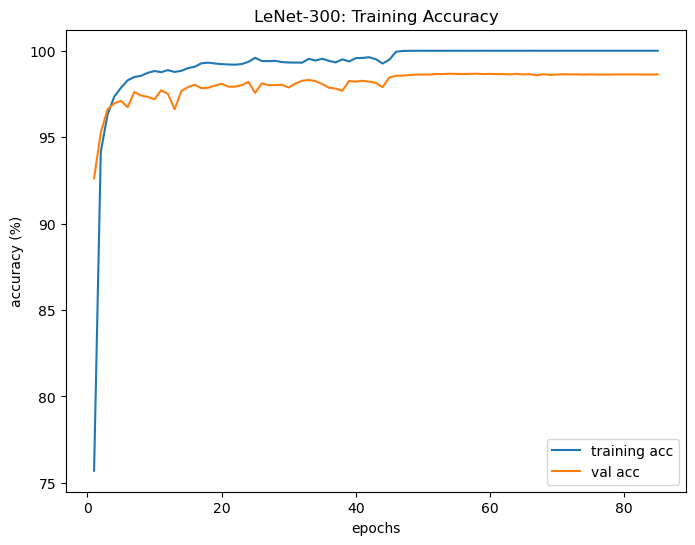

In [30]:
plt.figure(figsize = (8, 6))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['acc'] for k in training_history_lr_scheduler.keys()], label = 'training acc')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_acc'] for k in training_history_lr_scheduler.keys()], label = 'val acc')
plt.title("LeNet-300: Training Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy (%)")
plt.legend(loc = 'best')
plt.show()

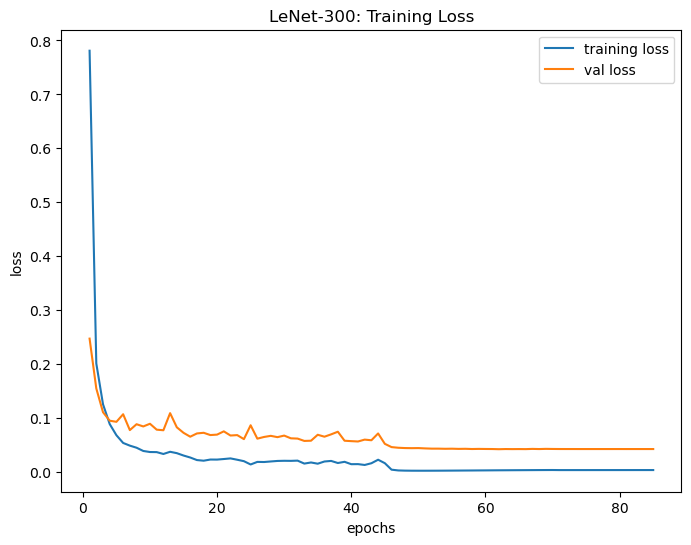

In [31]:
plt.figure(figsize = (8, 6))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['loss'] for k in training_history_lr_scheduler.keys()], label = 'training loss')
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['val_loss'] for k in training_history_lr_scheduler.keys()], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = 'best')
plt.title("LeNet-300: Training Loss")
plt.show()

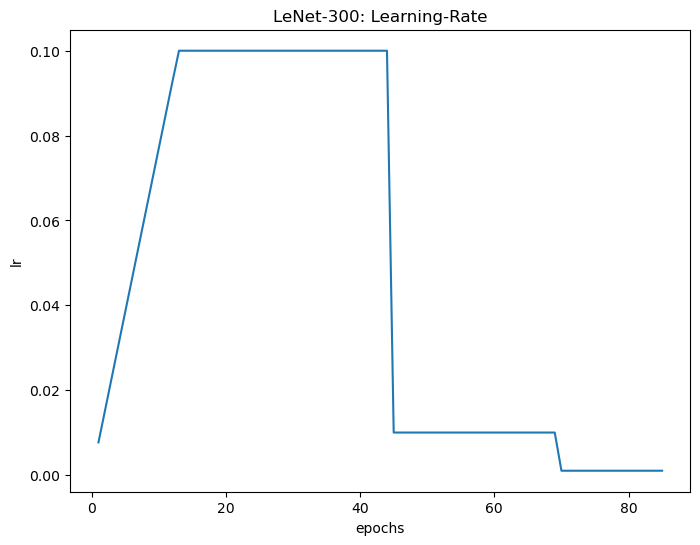

In [32]:
plt.figure(figsize = (8, 6))
plt.plot(list(training_history_lr_scheduler.keys()), [training_history_lr_scheduler[k]['lr'] for k in training_history_lr_scheduler.keys()])
plt.xlabel("epochs")
plt.ylabel("lr")
plt.title("LeNet-300: Learning-Rate")
plt.show()

In [33]:
del model

In [34]:
# Load 'best' trained parameters-
best_model = LeNet300()
best_model.load_state_dict(torch.load("LeNet300_best_model.pth"))
best_model = best_model.to(device)

In [35]:
val_loss, val_acc = test_model_progress(
    best_model, test_loader,
    test_dataset
)

Validation: : 100%|██████████████████████████████████| 40/40 [00:01<00:00, 25.64batch/s, val_acc=98.7, val_loss=0.0433]


In [36]:
print("LeNet-300 'best' trained metrics: ",
      f"loss: {val_loss:.4f} & accuracy = {val_acc:.2f}%"
     )

LeNet-300 'best' trained metrics:  loss: 0.0433 & accuracy = 98.67%
